In [1]:
%matplotlib inline
from scipy.optimize import dual_annealing
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import Matern
from collections import Counter
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from tqdm import tqdm
from datetime import datetime
import itertools
from itertools import permutations
from scipy.spatial import distance_matrix
import matplotlib
import matplotlib.colors as mcolors
from sklearn import metrics

### Lognormal for the whole UK

In [2]:
### load lognorm
model_version = 0
target_distribution = "lognormal_hurdle"
base_nn = "HConvLSTM_tdscale" #(Keep this fixed)

# Run this to get the prediction data in a variable named city_data
# Getting data
sys.path.append('../')
import glms
import pickle
import torch

path_ = f"Checkpoints/uk_rain_DGLM_{base_nn}_{target_distribution}/lightninlog_logs/version_{model_version}/"
ckpt_path = glms.NeuralDGLM.get_ckpt_path(os.path.join(path_,"checkpoints"))
print([path_,ckpt_path])
scaler_features, scaler_target = glms.NeuralDGLM.load_scalers(path_)
model = glms.NeuralDGLM.load_from_checkpoint(ckpt_path, save_hparams=False, scaler_features=scaler_features, scaler_target=scaler_target)
model.freeze()
model.eval()

test_output = pickle.load( open(os.path.join(path_,"test_output_2014_2019-07.pkl"),"rb") )
#########

['Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_lognormal_hurdle/lightning_logs/version_0/', 'Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_lognormal_hurdle/lightning_logs/version_0/checkpoints/epoch=5-step=10608-val_loss_loss=-1.058-val_metric_mse_rain=50.054.ckpt']


c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
loc_lat_lon = ['lat_57.75_56.15_lon_-5.75_-4.15', 'lat_53.75_52.15_lon_-3.35_-1.75', 'lat_53.75_52.15_lon_-2.95_-1.35', 'lat_55.75_54.15_lon_-5.35_-3.75', 'lat_55.75_54.15_lon_-4.95_-3.35', 'lat_53.35_51.75_lon_-0.95_0.65', 'lat_52.95_51.35_lon_-10.95_-9.35', 'lat_54.95_53.35_lon_-9.75_-8.15', 'lat_54.95_53.35_lon_-9.35_-7.75', 'lat_51.75_50.15_lon_-4.95_-3.35', 'lat_51.75_50.15_lon_-4.55_-2.95', 'lat_54.55_52.95_lon_-5.75_-4.15', 'lat_54.55_52.95_lon_-5.35_-3.75', 'lat_51.35_49.75_lon_-0.55_1.05', 'lat_51.35_49.75_lon_-0.15_1.45', 'lat_54.15_52.55_lon_-2.55_-0.95', 'lat_54.15_52.55_lon_-2.15_-0.55', 'lat_57.35_55.75_lon_-3.75_-2.15', 'lat_57.35_55.75_lon_-3.35_-1.75', 'lat_53.35_51.75_lon_-10.95_-9.35', 'lat_53.35_51.75_lon_-10.55_-8.95', 'lat_55.35_53.75_lon_-10.95_-9.35', 'lat_55.35_53.75_lon_-10.55_-8.95', 'lat_52.95_51.35_lon_-8.55_-6.95', 'lat_52.95_51.35_lon_-8.15_-6.55', 'lat_54.95_53.35_lon_-6.95_-5.35', 'lat_54.95_53.35_lon_-6.55_-4.95', 'lat_51.75_50.15_lon_-2.15_-0.55', 'lat_51.75_50.15_lon_-1.75_-0.15', 'lat_54.15_52.55_lon_-9.35_-7.75', 'lat_54.15_52.55_lon_-8.95_-7.35', 'lat_57.75_56.15_lon_-5.35_-3.75', 'lat_53.75_52.15_lon_-2.55_-0.95', 'lat_55.75_54.15_lon_-4.55_-2.95', 'lat_52.95_51.35_lon_-10.55_-8.95', 'lat_54.95_53.35_lon_-8.95_-7.35', 'lat_51.75_50.15_lon_-4.15_-2.55', 'lat_54.55_52.95_lon_-4.95_-3.35', 'lat_51.35_49.75_lon_0.25_1.85', 'lat_54.15_52.55_lon_-1.75_-0.15', 'lat_56.95_55.35_lon_-5.75_-4.15', 'lat_53.35_51.75_lon_-10.15_-8.55', 'lat_55.35_53.75_lon_-10.15_-8.55', 'lat_52.95_51.35_lon_-7.75_-6.15', 'lat_54.95_53.35_lon_-6.15_-4.55', 'lat_51.75_50.15_lon_-1.35_0.25', 'lat_54.15_52.55_lon_-8.55_-6.95', 'lat_57.35_55.75_lon_-5.75_-4.15', 'lat_53.75_52.15_lon_-2.15_-0.55', 'lat_55.75_54.15_lon_-4.15_-2.55', 'lat_52.95_51.35_lon_-10.15_-8.55', 'lat_54.95_53.35_lon_-8.55_-6.95', 'lat_51.75_50.15_lon_-3.75_-2.15', 'lat_54.55_52.95_lon_-4.55_-2.95', 'lat_51.35_49.75_lon_0.65_2.25', 'lat_54.15_52.55_lon_-1.35_0.25', 'lat_56.95_55.35_lon_-5.35_-3.75', 'lat_53.35_51.75_lon_-9.75_-8.15', 'lat_55.35_53.75_lon_-9.75_-8.15', 'lat_52.95_51.35_lon_-7.35_-5.75', 'lat_54.95_53.35_lon_-5.75_-4.15', 'lat_51.75_50.15_lon_-0.95_0.65', 'lat_54.15_52.55_lon_-8.15_-6.55', 'lat_57.35_55.75_lon_-5.35_-3.75', 'lat_53.75_52.15_lon_-1.75_-0.15', 'lat_55.75_54.15_lon_-3.75_-2.15', 'lat_52.95_51.35_lon_-9.75_-8.15', 'lat_54.95_53.35_lon_-8.15_-6.55', 'lat_51.75_50.15_lon_-3.35_-1.75', 'lat_54.55_52.95_lon_-4.15_-2.55', 'lat_51.35_49.75_lon_1.05_2.65', 'lat_54.15_52.55_lon_-0.95_0.65', 'lat_56.95_55.35_lon_-4.95_-3.35', 'lat_53.35_51.75_lon_-9.35_-7.75', 'lat_55.35_53.75_lon_-9.35_-7.75', 'lat_52.95_51.35_lon_-6.95_-5.35', 'lat_54.95_53.35_lon_-5.35_-3.75', 'lat_51.75_50.15_lon_-0.55_1.05', 'lat_54.15_52.55_lon_-7.75_-6.15', 'lat_57.35_55.75_lon_-4.95_-3.35', 'lat_53.75_52.15_lon_-1.35_0.25', 'lat_55.75_54.15_lon_-3.35_-1.75', 'lat_52.95_51.35_lon_-9.35_-7.75', 'lat_54.95_53.35_lon_-7.75_-6.15', 'lat_51.75_50.15_lon_-2.95_-1.35', 'lat_54.55_52.95_lon_-3.75_-2.15', 'lat_50.95_49.35_lon_-6.55_-4.95', 'lat_53.75_52.15_lon_-10.95_-9.35', 'lat_56.95_55.35_lon_-4.55_-2.95', 'lat_53.35_51.75_lon_-8.95_-7.35', 'lat_55.35_53.75_lon_-8.95_-7.35', 'lat_52.95_51.35_lon_-6.55_-4.95', 'lat_54.95_53.35_lon_-4.95_-3.35', 'lat_51.75_50.15_lon_-0.15_1.45', 'lat_54.15_52.55_lon_-7.35_-5.75', 'lat_57.35_55.75_lon_-4.55_-2.95', 'lat_53.75_52.15_lon_-0.95_0.65', 'lat_55.75_54.15_lon_-2.95_-1.35', 'lat_52.95_51.35_lon_-8.95_-7.35', 'lat_54.95_53.35_lon_-7.35_-5.75', 'lat_51.75_50.15_lon_-2.55_-0.95', 'lat_54.55_52.95_lon_-3.35_-1.75', 'lat_50.95_49.35_lon_-6.15_-4.55', 'lat_53.75_52.15_lon_-10.55_-8.95', 'lat_56.95_55.35_lon_-4.15_-2.55', 'lat_53.35_51.75_lon_-8.55_-6.95', 'lat_55.35_53.75_lon_-8.55_-6.95', 'lat_52.95_51.35_lon_-6.15_-4.55', 'lat_54.95_53.35_lon_-4.55_-2.95', 'lat_51.75_50.15_lon_0.25_1.85', 'lat_54.15_52.55_lon_-6.95_-5.35', 'lat_57.35_55.75_lon_-4.15_-2.55', 'lat_54.55_52.95_lon_-2.95_-1.35', 'lat_50.95_49.35_lon_-5.75_-4.15', 'lat_53.75_52.15_lon_-10.15_-8.55', 'lat_56.95_55.35_lon_-3.75_-2.15', 'lat_53.35_51.75_lon_-8.15_-6.55', 'lat_55.35_53.75_lon_-8.15_-6.55', 'lat_52.95_51.35_lon_-5.75_-4.15', 'lat_54.95_53.35_lon_-4.15_-2.55', 'lat_51.75_50.15_lon_0.65_2.25', 'lat_54.15_52.55_lon_-6.55_-4.95', 'lat_54.55_52.95_lon_-2.55_-0.95', 'lat_50.95_49.35_lon_-5.35_-3.75', 'lat_53.75_52.15_lon_-9.75_-8.15', 'lat_56.95_55.35_lon_-3.35_-1.75', 'lat_53.35_51.75_lon_-7.75_-6.15', 'lat_55.35_53.75_lon_-7.75_-6.15', 'lat_52.95_51.35_lon_-5.35_-3.75', 'lat_54.95_53.35_lon_-3.75_-2.15', 'lat_51.75_50.15_lon_1.05_2.65', 'lat_54.15_52.55_lon_-6.15_-4.55', 'lat_54.55_52.95_lon_-2.15_-0.55', 'lat_50.95_49.35_lon_-4.95_-3.35', 'lat_53.75_52.15_lon_-9.35_-7.75', 'lat_56.55_54.95_lon_-5.75_-4.15', 'lat_53.35_51.75_lon_-7.35_-5.75', 'lat_55.35_53.75_lon_-7.35_-5.75', 'lat_52.95_51.35_lon_-4.95_-3.35', 'lat_54.95_53.35_lon_-3.35_-1.75', 'lat_51.35_49.75_lon_-6.55_-4.95', 'lat_54.15_52.55_lon_-5.75_-4.15', 'lat_54.15_52.55_lon_-10.95_-9.35', 'lat_50.95_49.35_lon_-4.55_-2.95', 'lat_53.75_52.15_lon_-8.95_-7.35', 'lat_56.55_54.95_lon_-5.35_-3.75', 'lat_53.35_51.75_lon_-6.95_-5.35', 'lat_55.35_53.75_lon_-6.95_-5.35', 'lat_52.95_51.35_lon_-4.55_-2.95', 'lat_54.95_53.35_lon_-2.95_-1.35', 'lat_51.35_49.75_lon_-6.15_-4.55', 'lat_54.15_52.55_lon_-5.35_-3.75', 'lat_54.15_52.55_lon_-10.55_-8.95', 'lat_50.95_49.35_lon_-4.15_-2.55', 'lat_53.75_52.15_lon_-8.55_-6.95', 'lat_56.55_54.95_lon_-4.95_-3.35', 'lat_53.35_51.75_lon_-6.55_-4.95', 'lat_55.35_53.75_lon_-6.55_-4.95', 'lat_52.95_51.35_lon_-4.15_-2.55', 'lat_54.95_53.35_lon_-2.55_-0.95', 'lat_51.35_49.75_lon_-5.75_-4.15', 'lat_54.15_52.55_lon_-4.95_-3.35', 'lat_54.15_52.55_lon_-10.15_-8.55', 'lat_50.95_49.35_lon_-3.75_-2.15', 'lat_53.75_52.15_lon_-8.15_-6.55', 'lat_56.55_54.95_lon_-4.55_-2.95', 'lat_53.35_51.75_lon_-6.15_-4.55', 'lat_55.35_53.75_lon_-6.15_-4.55', 'lat_52.95_51.35_lon_-3.75_-2.15', 'lat_54.55_52.95_lon_-10.95_-9.35', 'lat_51.35_49.75_lon_-5.35_-3.75', 'lat_54.15_52.55_lon_-4.55_-2.95', 'lat_54.15_52.55_lon_-9.75_-8.15', 'lat_50.95_49.35_lon_-3.35_-1.75', 'lat_53.75_52.15_lon_-7.75_-6.15', 'lat_56.55_54.95_lon_-4.15_-2.55', 'lat_53.35_51.75_lon_-5.75_-4.15', 'lat_55.35_53.75_lon_-5.75_-4.15', 'lat_52.95_51.35_lon_-3.35_-1.75', 'lat_54.55_52.95_lon_-10.55_-8.95', 'lat_51.35_49.75_lon_-4.95_-3.35', 'lat_54.15_52.55_lon_-4.15_-2.55', 'lat_50.95_49.35_lon_-2.95_-1.35', 'lat_53.75_52.15_lon_-7.35_-5.75', 'lat_56.55_54.95_lon_-3.75_-2.15', 'lat_53.35_51.75_lon_-5.35_-3.75', 'lat_55.35_53.75_lon_-5.35_-3.75', 'lat_52.95_51.35_lon_-2.95_-1.35', 'lat_54.55_52.95_lon_-10.15_-8.55', 'lat_51.35_49.75_lon_-4.55_-2.95', 'lat_54.15_52.55_lon_-3.75_-2.15', 'lat_50.95_49.35_lon_-2.55_-0.95', 'lat_53.75_52.15_lon_-6.95_-5.35', 'lat_56.55_54.95_lon_-3.35_-1.75', 'lat_53.35_51.75_lon_-4.95_-3.35', 'lat_55.35_53.75_lon_-4.95_-3.35', 'lat_52.95_51.35_lon_-2.55_-0.95', 'lat_54.55_52.95_lon_-9.75_-8.15', 'lat_51.35_49.75_lon_-4.15_-2.55', 'lat_54.15_52.55_lon_-3.35_-1.75', 'lat_54.15_52.55_lon_-2.95_-1.35', 'lat_50.95_49.35_lon_-2.15_-0.55', 'lat_53.75_52.15_lon_-6.55_-4.95', 'lat_56.15_54.55_lon_-5.75_-4.15', 'lat_53.35_51.75_lon_-4.55_-2.95', 'lat_55.35_53.75_lon_-4.55_-2.95', 'lat_52.95_51.35_lon_-2.15_-0.55', 'lat_54.55_52.95_lon_-9.35_-7.75', 'lat_51.35_49.75_lon_-3.75_-2.15', 'lat_50.95_49.35_lon_-1.75_-0.15', 'lat_53.75_52.15_lon_-6.15_-4.55', 'lat_56.15_54.55_lon_-5.35_-3.75', 'lat_53.35_51.75_lon_-4.15_-2.55', 'lat_55.35_53.75_lon_-4.15_-2.55', 'lat_52.95_51.35_lon_-1.75_-0.15', 'lat_54.55_52.95_lon_-8.95_-7.35', 'lat_51.35_49.75_lon_-3.35_-1.75', 'lat_50.95_49.35_lon_-1.35_0.25', 'lat_53.75_52.15_lon_-5.75_-4.15', 'lat_56.15_54.55_lon_-4.95_-3.35', 'lat_53.35_51.75_lon_-3.75_-2.15', 'lat_55.35_53.75_lon_-3.75_-2.15', 'lat_52.95_51.35_lon_-1.35_0.25', 'lat_54.55_52.95_lon_-8.55_-6.95', 'lat_51.35_49.75_lon_-2.95_-1.35', 'lat_50.95_49.35_lon_-0.95_0.65', 'lat_53.75_52.15_lon_-5.35_-3.75', 'lat_56.15_54.55_lon_-4.55_-2.95', 'lat_53.35_51.75_lon_-3.35_-1.75', 'lat_55.35_53.75_lon_-3.35_-1.75', 'lat_52.95_51.35_lon_-0.95_0.65', 'lat_54.55_52.95_lon_-8.15_-6.55', 'lat_51.35_49.75_lon_-2.55_-0.95', 'lat_50.95_49.35_lon_-0.55_1.05', 'lat_53.75_52.15_lon_-4.95_-3.35', 'lat_56.15_54.55_lon_-4.15_-2.55', 'lat_53.35_51.75_lon_-2.95_-1.35', 'lat_55.35_53.75_lon_-2.95_-1.35', 'lat_51.75_50.15_lon_-6.55_-4.95', 'lat_54.55_52.95_lon_-7.75_-6.15', 'lat_51.35_49.75_lon_-2.15_-0.55', 'lat_50.95_49.35_lon_-0.15_1.45', 'lat_53.75_52.15_lon_-4.55_-2.95', 'lat_56.15_54.55_lon_-3.75_-2.15', 'lat_53.35_51.75_lon_-2.55_-0.95', 'lat_54.95_53.35_lon_-10.95_-9.35', 'lat_51.75_50.15_lon_-6.15_-4.55', 'lat_54.55_52.95_lon_-7.35_-5.75', 'lat_51.35_49.75_lon_-1.75_-0.15', 'lat_50.95_49.35_lon_0.25_1.85', 'lat_53.75_52.15_lon_-4.15_-2.55', 'lat_56.15_54.55_lon_-3.35_-1.75', 'lat_53.35_51.75_lon_-2.15_-0.55', 'lat_54.95_53.35_lon_-10.55_-8.95', 'lat_51.75_50.15_lon_-5.75_-4.15', 'lat_54.55_52.95_lon_-6.95_-5.35', 'lat_51.35_49.75_lon_-1.35_0.25', 'lat_50.95_49.35_lon_0.65_2.25', 'lat_53.75_52.15_lon_-3.75_-2.15', 'lat_55.75_54.15_lon_-5.75_-4.15', 'lat_53.35_51.75_lon_-1.75_-0.15', 'lat_54.95_53.35_lon_-10.15_-8.55', 'lat_51.75_50.15_lon_-5.35_-3.75', 'lat_54.55_52.95_lon_-6.55_-4.95', 'lat_51.35_49.75_lon_-0.95_0.65', 'lat_53.35_51.75_lon_-1.35_0.25', 'lat_54.55_52.95_lon_-6.15_-4.55']
output_keys = ['pred_mu', 'pred_disp', 'target_did_rain', 'target_rain_value', 'date', 'pred_p']

In [51]:
lognorm_outputs = [[[],[],[],[],[],[]] for places in range(len(loc_lat_lon))] 
for location_idx in range(len(loc_lat_lon)):
    lognorm_outputs[location_idx].append([float(loc_lat_lon[location_idx].split('_')[i]) for i in [1,2,4,5]])
    for output_idx in range(6):
        for week in range(286):
            for day in range(7):
                #check for date, as date is formatted differently from the rest.
                if output_idx==4:
                    if day==0:
                        lognorm_outputs[location_idx][output_idx].append(np.array(test_output[loc_lat_lon[location_idx]][output_keys[output_idx]][week],dtype='datetime64[D]'))
                    else:
                        lognorm_outputs[location_idx][output_idx].append('')                   
                else:
                    lognorm_outputs[location_idx][output_idx].append(test_output[loc_lat_lon[location_idx]][output_keys[output_idx]][week][day])


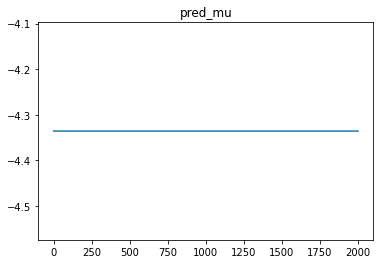

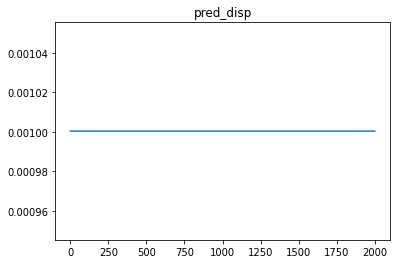

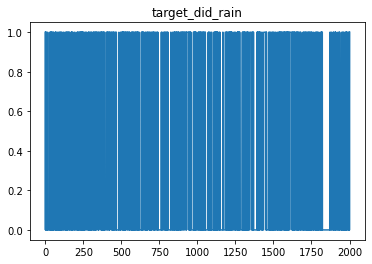

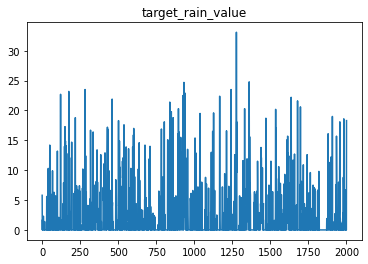

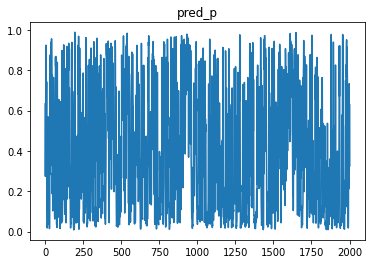

In [30]:
for k in [0,1,2,3,5]:
    plt.plot(range(2002),[lognorm_outputs[100][k][i][3][2]for i in range(2002)])
    plt.title(output_keys[k])
    plt.show()

In [68]:
from sklearn.metrics import roc_curve, auc
from math import exp
import numpy as np
import scipy.stats as scs

#Here:
# 0 'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'date', 5'pred_p', 6'location'.
#[place][parameter][day][row][column]
#Old:
#0:i,1:location,2:pred_mu,3:pred_disp,4:pred_p,5:target_rain_value,6:dates

log_0mm=[]
log_0mm_cdfx=[]

for place in tqdm(lognorm_outputs):
    for day in range(500,510):
            for row in range(4):
                for column in range(4):
                            
                    #vector of 'did it rain this much'
                    if place[3][day][row][column]>0.1:
                        log_0mm.append(1)
                    else:
                        log_0mm.append(0)
                    #vetor of 'probability it rained this much'
                    log_0mm_cdfx.append(1-((1-place[5][day][row][column])+(place[5][day][row][column]*scs.lognorm(s=place[1][day][row][column],scale=np.exp(place[0][day][row][column])).cdf(0.1))))

  
print('0 done')
log_5mm=[]
log_5mm_cdfx=[]

for place in tqdm(lognorm_outputs):
    for day in range(500,510):
        for row in range(4):
                for column in range(4):
                                       
                    #vector of 'did it rain this much'
                    if place[3][day][row][column]>5:
                        log_5mm.append(1)
                    else:
                        log_5mm.append(0)
                    log_5mm_cdfx.append(1-((1-place[5][day][row][column])+(place[5][day][row][column]*scs.lognorm(s=place[1][day][row][column],scale=np.exp(place[0][day][row][column])).cdf(5))))

                    #vetor of 'probability it rained this much'
print('5 done')



log_10mm=[]
log_10mm_cdfx=[]

for place in tqdm(lognorm_outputs):
    for day in range(500,510):
        for row in range(4):
                for column in range(4):
                    #vector of 'did it rain this much'
                    if place[3][day][row][column]>10:
                        log_10mm.append(1)
                    else:
                        log_10mm.append(0)
                    #vetor of 'probability it rained this much'
                    log_10mm_cdfx.append(1-((1-place[5][day][row][column])+(place[5][day][row][column]*scs.lognorm(s=place[1][day][row][column],scale=np.exp(place[0][day][row][column])).cdf(10))))
print('10 done')

log_15mm=[]
log_15mm_cdfx=[]

for place in tqdm(lognorm_outputs):
    for day in range(500,510):
        for row in range(4):
                for column in range(4):
                    #vector of 'did it rain this much'
                    if place[3][day][row][column]>15:
                        log_15mm.append(1)
                    else:
                        log_15mm.append(0)
                    #vetor of 'probability it rained this much'
                    log_15mm_cdfx.append(1-((1-place[5][day][row][column])+(place[5][day][row][column]*scs.lognorm(s=place[1][day][row][column],scale=np.exp(place[0][day][row][column])).cdf(15))))
print('15 done')


log_20mm=[]
log_20mm_cdfx=[]

for place in tqdm(lognorm_outputs):
    for day in range(500,510):
        for row in range(4):
                for column in range(4):
                    #vector of 'did it rain this much'
                    if place[3][day][row][column]>20:
                        log_20mm.append(1)
                    else:
                        log_20mm.append(0)
                    #vetor of 'probability it rained this much'
                    log_20mm_cdfx.append(1-((1-place[5][day][row][column])+(place[5][day][row][column]*scs.lognorm(s=place[1][day][row][column],scale=np.exp(place[0][day][row][column])).cdf(20))))
print('20 done')


log_25mm=[]
log_25mm_cdfx=[]

for place in tqdm(lognorm_outputs):
    for day in range(500,510):
        for row in range(4):
                for column in range(4):
                    #vector of 'did it rain this much'
                    if place[3][day][row][column]>25:
                        log_25mm.append(1)
                    else:
                        log_25mm.append(0)
                    #vetor of 'probability it rained this much'
                    log_25mm_cdfx.append(1-((1-place[5][day][row][column])+(place[5][day][row][column]*scs.lognorm(s=place[1][day][row][column],scale=np.exp(place[0][day][row][column])).cdf(25))))
print('25 done')

100%|██████████| 267/267 [00:23<00:00, 11.32it/s]


0 done


100%|██████████| 267/267 [00:24<00:00, 11.09it/s]


5 done


100%|██████████| 267/267 [00:24<00:00, 10.97it/s]


10 done


100%|██████████| 267/267 [00:24<00:00, 10.95it/s]


15 done


100%|██████████| 267/267 [00:23<00:00, 11.39it/s]


20 done


100%|██████████| 267/267 [00:22<00:00, 11.80it/s]

25 done


In [72]:
log_10mm_cdfx

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

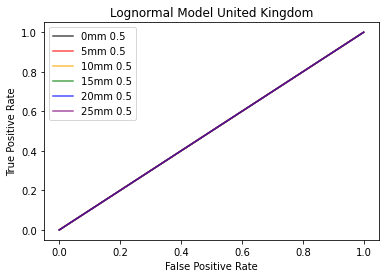

In [69]:
fpr_0mm, tpr_0mm, _ = metrics.roc_curve(log_0mm,log_0mm_cdfx)
auc0 = metrics.roc_auc_score(log_0mm,log_0mm_cdfx)
plt.plot(fpr_0mm,tpr_0mm,label='AUC='+str(auc0),color='black',alpha=0.7)

fpr_5mm, tpr_5mm, _ = metrics.roc_curve(log_5mm,log_5mm_cdfx)
auc5 = metrics.roc_auc_score(log_5mm,log_5mm_cdfx)
plt.plot(fpr_5mm,tpr_5mm,label='AUC='+str(auc5),color='red',alpha=0.7)

fpr_10mm, tpr_10mm, _ = metrics.roc_curve(log_10mm,log_10mm_cdfx)
auc10 = metrics.roc_auc_score(log_10mm,log_10mm_cdfx)
plt.plot(fpr_10mm,tpr_10mm,label='AUC='+str(auc10),color='orange',alpha=0.7)

fpr_15mm, tpr_15mm, _ = metrics.roc_curve(log_15mm,log_15mm_cdfx)
auc15 = metrics.roc_auc_score(log_15mm,log_15mm_cdfx)
plt.plot(fpr_15mm,tpr_15mm,label='AUC='+str(auc15),color='green',alpha=0.7)

fpr_20mm, tpr_20mm, _ = metrics.roc_curve(log_20mm,log_20mm_cdfx)
auc20 = metrics.roc_auc_score(log_20mm,log_20mm_cdfx)
plt.plot(fpr_20mm,tpr_20mm,label='AUC='+str(auc20),color='blue',alpha=0.7)

fpr_25mm, tpr_25mm, _ = metrics.roc_curve(log_25mm,log_25mm_cdfx)
auc25 = metrics.roc_auc_score(log_25mm,log_25mm_cdfx)
plt.plot(fpr_25mm,tpr_25mm,label='AUC='+str(auc25),color='purple',alpha=0.7)

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(['0mm '+str(round(auc0,5)),'5mm '+str(round(auc5,5)),'10mm '+str(round(auc10,5)),'15mm '+str(round(auc15,5)),'20mm '+str(round(auc20,5)),'25mm '+str(round(auc25,5))])
plt.title('Lognormal Model United Kingdom')
plt.savefig('ROC Lognormal model UK')

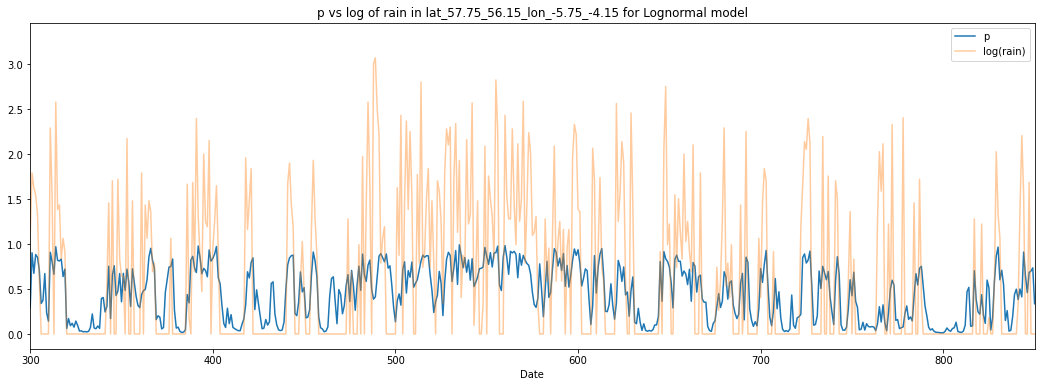

In [65]:
#p plot lognormal
import numpy as np
from matplotlib import pyplot as plt
plt.figure(figsize=(18, 6))
plt.plot(range(2002),[lognorm_outputs[1][5][i][0][0] for i in range(2002)])
plt.plot(range(2002),[0 if rain<1 else np.log(rain) for rain in [lognorm_outputs[1][3][i][0][0] for i in range(2002)]],'-',alpha=0.4)
plt.xlabel('Date')
plt.xlim([range(2002)[300],range(2002)[850]])
plt.legend(['p','log(rain)'],facecolor='white')
plt.title('p vs log of rain in lat_57.75_56.15_lon_-5.75_-4.15 for Lognormal model')
plt.savefig('lognorm_p_UK')


#### Mean is negative, giving 0 density. Failed trainig, unusable.